In [5]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os


In [6]:
root_folder = os.path.dirname(os.getcwd())
path_to_recording= path.join(root_folder,'data/synthesized/data_55.npy');
path_to_model = path.join(root_folder, 'models/detect/resnet18_num_classes_2_epoch_24.pt')
path_to_results = path.join(root_folder, 'data/results/eeg_ground_truth_dataset2.npy')
path_to_ground_truth_data = path.join(root_folder,'data/synthesized/gt_55.npy');

sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn

In [7]:
waveform_length = 72;
step_size = int(np.round(waveform_length * 0.1))



In [8]:
batch_size = 15000;
num_classes = 2;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = cnn.resnet18(num_classes=num_classes);
checkpoint = torch.load(path_to_model)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);

In [9]:
transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])
recording = cnn.Recording(path_to_recording, transform = transform);
recording = cnn.AddPaddingToRecording(recording, step_size, waveform_length)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]


In [10]:
waveform_indices = cnn.GetWaveformIndices(recording, step_size, waveform_length)

In [11]:
transform = transforms.Compose([cnn.ExtractWaveforms(waveform_indices, waveform_length)])
waveforms = transform(recording.data);



In [12]:
normalized_waveforms = waveforms;
dataset_to_infer = cnn.InferenceDataset(normalized_waveforms.to(device));

torch.cuda.FloatTensor


In [13]:
%pdb off
data_loader = torch.utils.data.DataLoader(dataset_to_infer, batch_size=batch_size, shuffle=False, num_workers=0);
result = cnn.Inference(model, data_loader, num_classes)

Automatic pdb calling has been turned OFF
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch

In [14]:
treshold = 0.9;
predictions = cnn.PredictionByTreshold(result, treshold)

In [19]:
max_amplitude = cnn.GetNonOverlappingSpikesMaxAmplitude(recording, predictions, waveform_length, waveform_indices)


In [20]:
print(max_amplitude)

[    1295     2478     3022 ... 14399490 14399731 14399840]


In [21]:
ground_truth = np.load(path_to_ground_truth_data);
neuron_indexes = ground_truth[1, :];
spike_positions = ground_truth[0, :];
spike_positions = spike_positions.astype(int)

spike_positions.shape
total = spike_positions.size
print(total)


14115


In [23]:

max_index_unique = max_amplitude


In [24]:
print(max_index_unique.shape)
np.save(path_to_results, max_index_unique)

(14743,)


In [25]:
is_found = np.zeros(max_index_unique.size)
for i in range(0, max_index_unique.size):
  found = np.where(max_index_unique[i] == spike_positions)
  if(len(found[0]) == 0):
    is_found[i] = 0
  else:
    is_found[i] = 1;

In [26]:
tp = np.where(is_found == 1)[0].size
print(tp)
fp = np.where(is_found == 0)[0].size
print(fp)


13425
1318


In [27]:
tp / total

0.9511158342189161

In [ ]:
recording1 = cnn.Recording(path_to_recording, transform = transform);
transform = transforms.Compose([cnn.Awgn(20), cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.OptimizedZScoreNormalizaton()])


1439718
1504


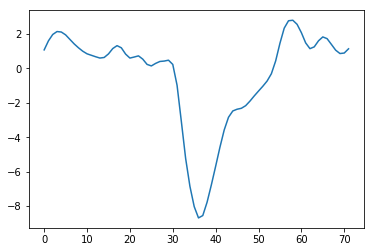

In [ ]:
import matplotlib.pyplot as plt
rnd = np.random.randint(spike_positions.size);
print(max_index_unique[rnd])
print(rnd)
plt.plot((recording.data[0, spike_positions[rnd] - 36:spike_positions[rnd]+36]).numpy().ravel())
plt.plot((recording1.data[0, spike_positions[rnd] - 36:spike_positions[rnd]+36]).numpy().ravel())

In [ ]:
for i in range(max_index_unique.size):
    plt.figure(i)

    plt.plot((recording.data[0, max_index_unique[i] - 36:max_index_unique[i]+36]).numpy().ravel())


/home/vtpc/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


for i in range(max_index_unique.size):
    plt.figure(i)
    plt.figure(i).suptitle(found[i], fontsize=16)

    plt.plot((recording.data[0, max_index_unique[i] - 36:max_index_unique[i]+36]).numpy().ravel())


In [ ]:
max_index_unique.size

In [ ]:
is_found = np.zeros(spike_positions.size)

for i in range(spike_positions.size):
  found = np.where(spike_positions[i] == predicted_index1)
  if(len(found[0]) == 0):
    is_found[i] = 0
  else:
    is_found[i] = 1;

    
    
    
tp = np.where(is_found == 1)[0].size
print(tp)
fp = np.where(is_found == 0)[0].size
print(fp)


In [ ]:
tp / total
